In [15]:
import os
import sys
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import richdem as rd
import metpy.calc as mpcalc
from metpy.units import units
import cmocean.cm as cmo
from datetime import datetime
import pandas as pd
from datetime import timedelta

# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import matplotlib.colors as mcolors

# import personal modules
sys.path.append('../modules')
import custom_cmaps as ccmap
from plotter import draw_basemap, get_every_other_vector, plot_terrain

In [2]:
path_to_data = '/expanse/nfs/cw3e/cwp140/'      # project data -- read only
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
ext = [-140., -130., 53., 63.]

In [4]:
fname = '/expanse/nfs/cw3e/cwp140/downloads/GEFSv12_reforecast/landsfc.pgrb2.0p25'
lsm = xr.open_dataset(fname, engine='cfgrib')
lsm = lsm.assign_coords({"longitude": (((lsm.longitude + 180) % 360) - 180)}) # Convert DataArray longitude coordinates from 0-359 to -180-179
lsm = lsm.reindex(latitude=list(reversed(lsm.latitude)))
lsm = lsm.sel(longitude=slice(ext[0], ext[1]), latitude=slice(ext[2], ext[3]))
lsm

<xarray.Dataset>
Dimensions:     (latitude: 41, longitude: 41)
Coordinates:
  * latitude    (latitude) float64 53.0 53.25 53.5 53.75 ... 62.5 62.75 63.0
  * longitude   (longitude) float64 -140.0 -139.8 -139.5 ... -130.2 -130.0
    number      int64 ...
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     float64 ...
    valid_time  datetime64[ns] ...
Data variables:
    lsm         (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          2
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2024-08-20T12:47 GRIB to CDM+CF via cfgrib-0.9.1...

In [5]:
fname = '/expanse/nfs/cw3e/cwp140/downloads/GEFSv12_reforecast/hgt_sfc_2000100100_c00.grib2'
ds = xr.open_dataset(fname, engine='cfgrib')
ds = ds.assign_coords({"longitude": (((ds.longitude + 180) % 360) - 180)}) # Convert DataArray longitude coordinates from 0-359 to -180-179
ds = ds.isel(step=1)
ds = ds.reindex(latitude=list(reversed(ds.latitude)))
ds = ds.sel(longitude=slice(ext[0], ext[1]), latitude=slice(ext[2], ext[3]))
ds


<xarray.Dataset>
Dimensions:     (latitude: 41, longitude: 41)
Coordinates:
  * latitude    (latitude) float64 53.0 53.25 53.5 53.75 ... 62.5 62.75 63.0
  * longitude   (longitude) float64 -140.0 -139.8 -139.5 ... -130.2 -130.0
    number      int64 ...
    time        datetime64[ns] ...
    step        timedelta64[ns] 06:00:00
    surface     float64 ...
    valid_time  datetime64[ns] ...
Data variables:
    orog        (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          2
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2024-08-20T12:47 GRIB to CDM+CF via cfgrib-0.9.1...

In [6]:
# orog = ds.orog.where(lsm.lsm == 1)
orog = ds.orog

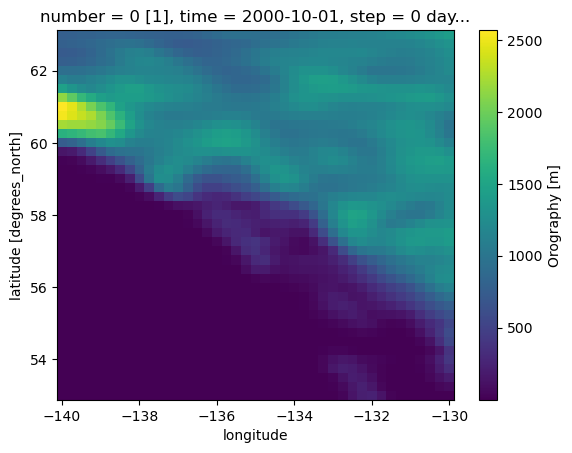

In [7]:
ds.orog.plot()

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.000399082===================  ] (97% - 0.0s - 1 threads)


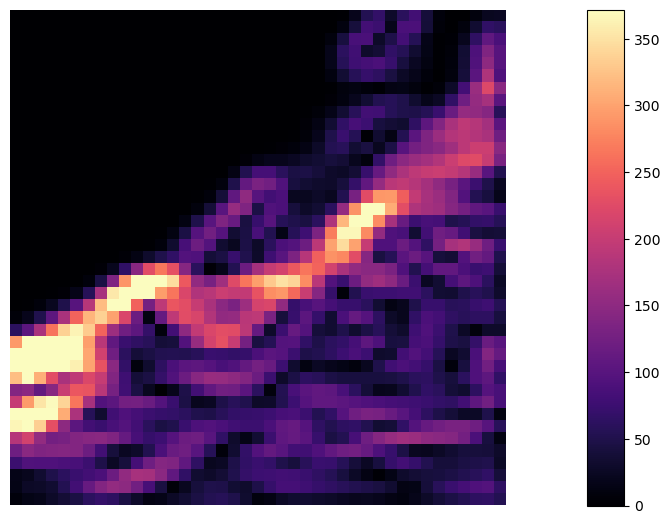

In [8]:
## load the data into rich dem
rda = rd.rdarray(orog.values, no_data=np.nan)
## calculate the slope
slope = rd.TerrainAttribute(rda, attrib='slope_riserun')
rd.rdShow(slope, axes=False, cmap='magma', figsize=(8, 5.5))
plt.show()

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.000314423===================  ] (97% - 0.0s - 1 threads)


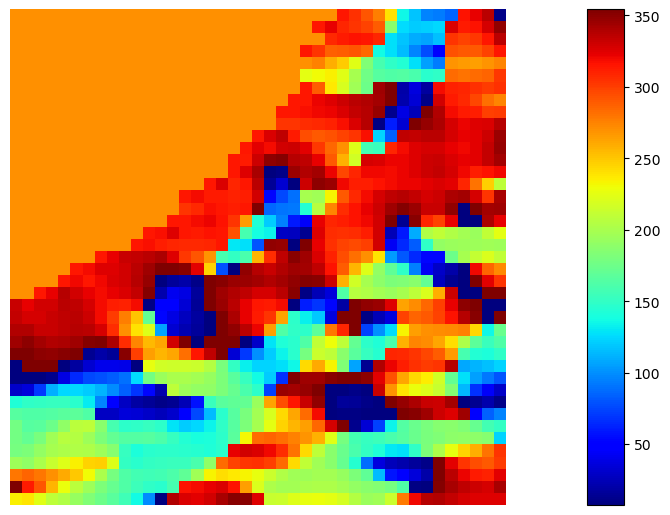

In [9]:
aspect = rd.TerrainAttribute(rda, attrib='aspect')
rd.rdShow(aspect, axes=False, cmap='jet', figsize=(8, 5.5))
plt.show()

In [10]:
## pull in IVT direction from forecast
## load the reforecast
## testing 162 hr lead from Nov 21, 2013
## TODO write the code so that it chooses the right fname based on lead, day, month, year
fname = path_to_data + 'preprocessed/GEFSv12_reforecast/ivt/20131115_ivt_F147_F168.nc'
forecast = xr.open_dataset(fname)
forecast = forecast.rename({'longitude': 'lon', 'latitude': 'lat', 'ivt': 'IVT', 'ivtu': 'uIVT', 'ivtv':'vIVT'}) # need to rename this to match GEFSv12 Reforecast
forecast = forecast.reindex(lat=list(reversed(forecast.lat)))
forecast = forecast.sel(lon=slice(ext[0], ext[1]), lat=slice(ext[2], ext[3]))
forecast = forecast.isel(step=-1) ### need to fix this so it selects the right time step based on input
forecast = forecast.mean('number') # ensemble mean


## testing 162 hr lead to Nov 21, 2023
fname = path_to_data + '/downloads/GFS_025d/GFS_IVT_2023111406_F162.nc'
forecast2 = xr.open_dataset(fname)
forecast2 = forecast2.rename({'lon_0': 'lon', 'lat_0': 'lat'}) # need to rename this to match GEFSv12 Reforecast
forecast2 = forecast2.assign_coords({"lon": (((forecast2.lon + 180) % 360) - 180)}) # Convert DataArray longitude coordinates from 0-359 to -180-179
forecast2 = forecast2.sel(lon=slice(ext[0], ext[1]), lat=slice(ext[2], ext[3]))
init_time = pd.to_datetime('2023111406', format='%Y%m%d%H')
valid_time = init_time + timedelta(hours=162)
forecast2 = forecast2.assign(valid_time=valid_time)
forecast2 = forecast2.assign(time=init_time)
forecast2

<xarray.Dataset>
Dimensions:     (lat: 41, lon: 41)
Coordinates:
  * lat         (lat) float32 53.0 53.25 53.5 53.75 ... 62.25 62.5 62.75 63.0
  * lon         (lon) float32 -140.0 -139.8 -139.5 ... -130.5 -130.2 -130.0
Data variables:
    IVT         (lat, lon) float32 ...
    uIVT        (lat, lon) float32 ...
    vIVT        (lat, lon) float32 ...
    valid_time  datetime64[ns] 2023-11-21
    time        datetime64[ns] 2023-11-14T06:00:00

In [11]:
forecast_lst = [forecast, forecast2]
fc_lst = []
for i, fc in enumerate(forecast_lst):
## calculate IVT direction 
    uvec = units.Quantity(fc['uIVT'].values, "m/s")
    vvec = units.Quantity(fc['vIVT'].values, "m/s")
    ivtdir = mpcalc.wind_direction(uvec, vvec)
    # forecast['ivtdir'] = ivtdir
    
    fc = fc.assign(ivtdir=(['lat','lon'],ivtdir.magnitude))
    fc = fc.assign(aspect=(['lat','lon'],np.asarray(aspect)))
    fc = fc.assign(diff_dir=(['lat','lon'],((ivtdir.magnitude-aspect) % 360)))
    fc_lst.append(fc)

In [12]:
# Set up projection
# mapcrs = ccrs.Mercator()
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
lats = forecast.lat.values
lons = forecast.lon.values
r = 2
dx = np.arange(lons.min().round(),lons.max().round()+r,r)
dy = np.arange(lats.min().round(),lats.max().round()+r,r)

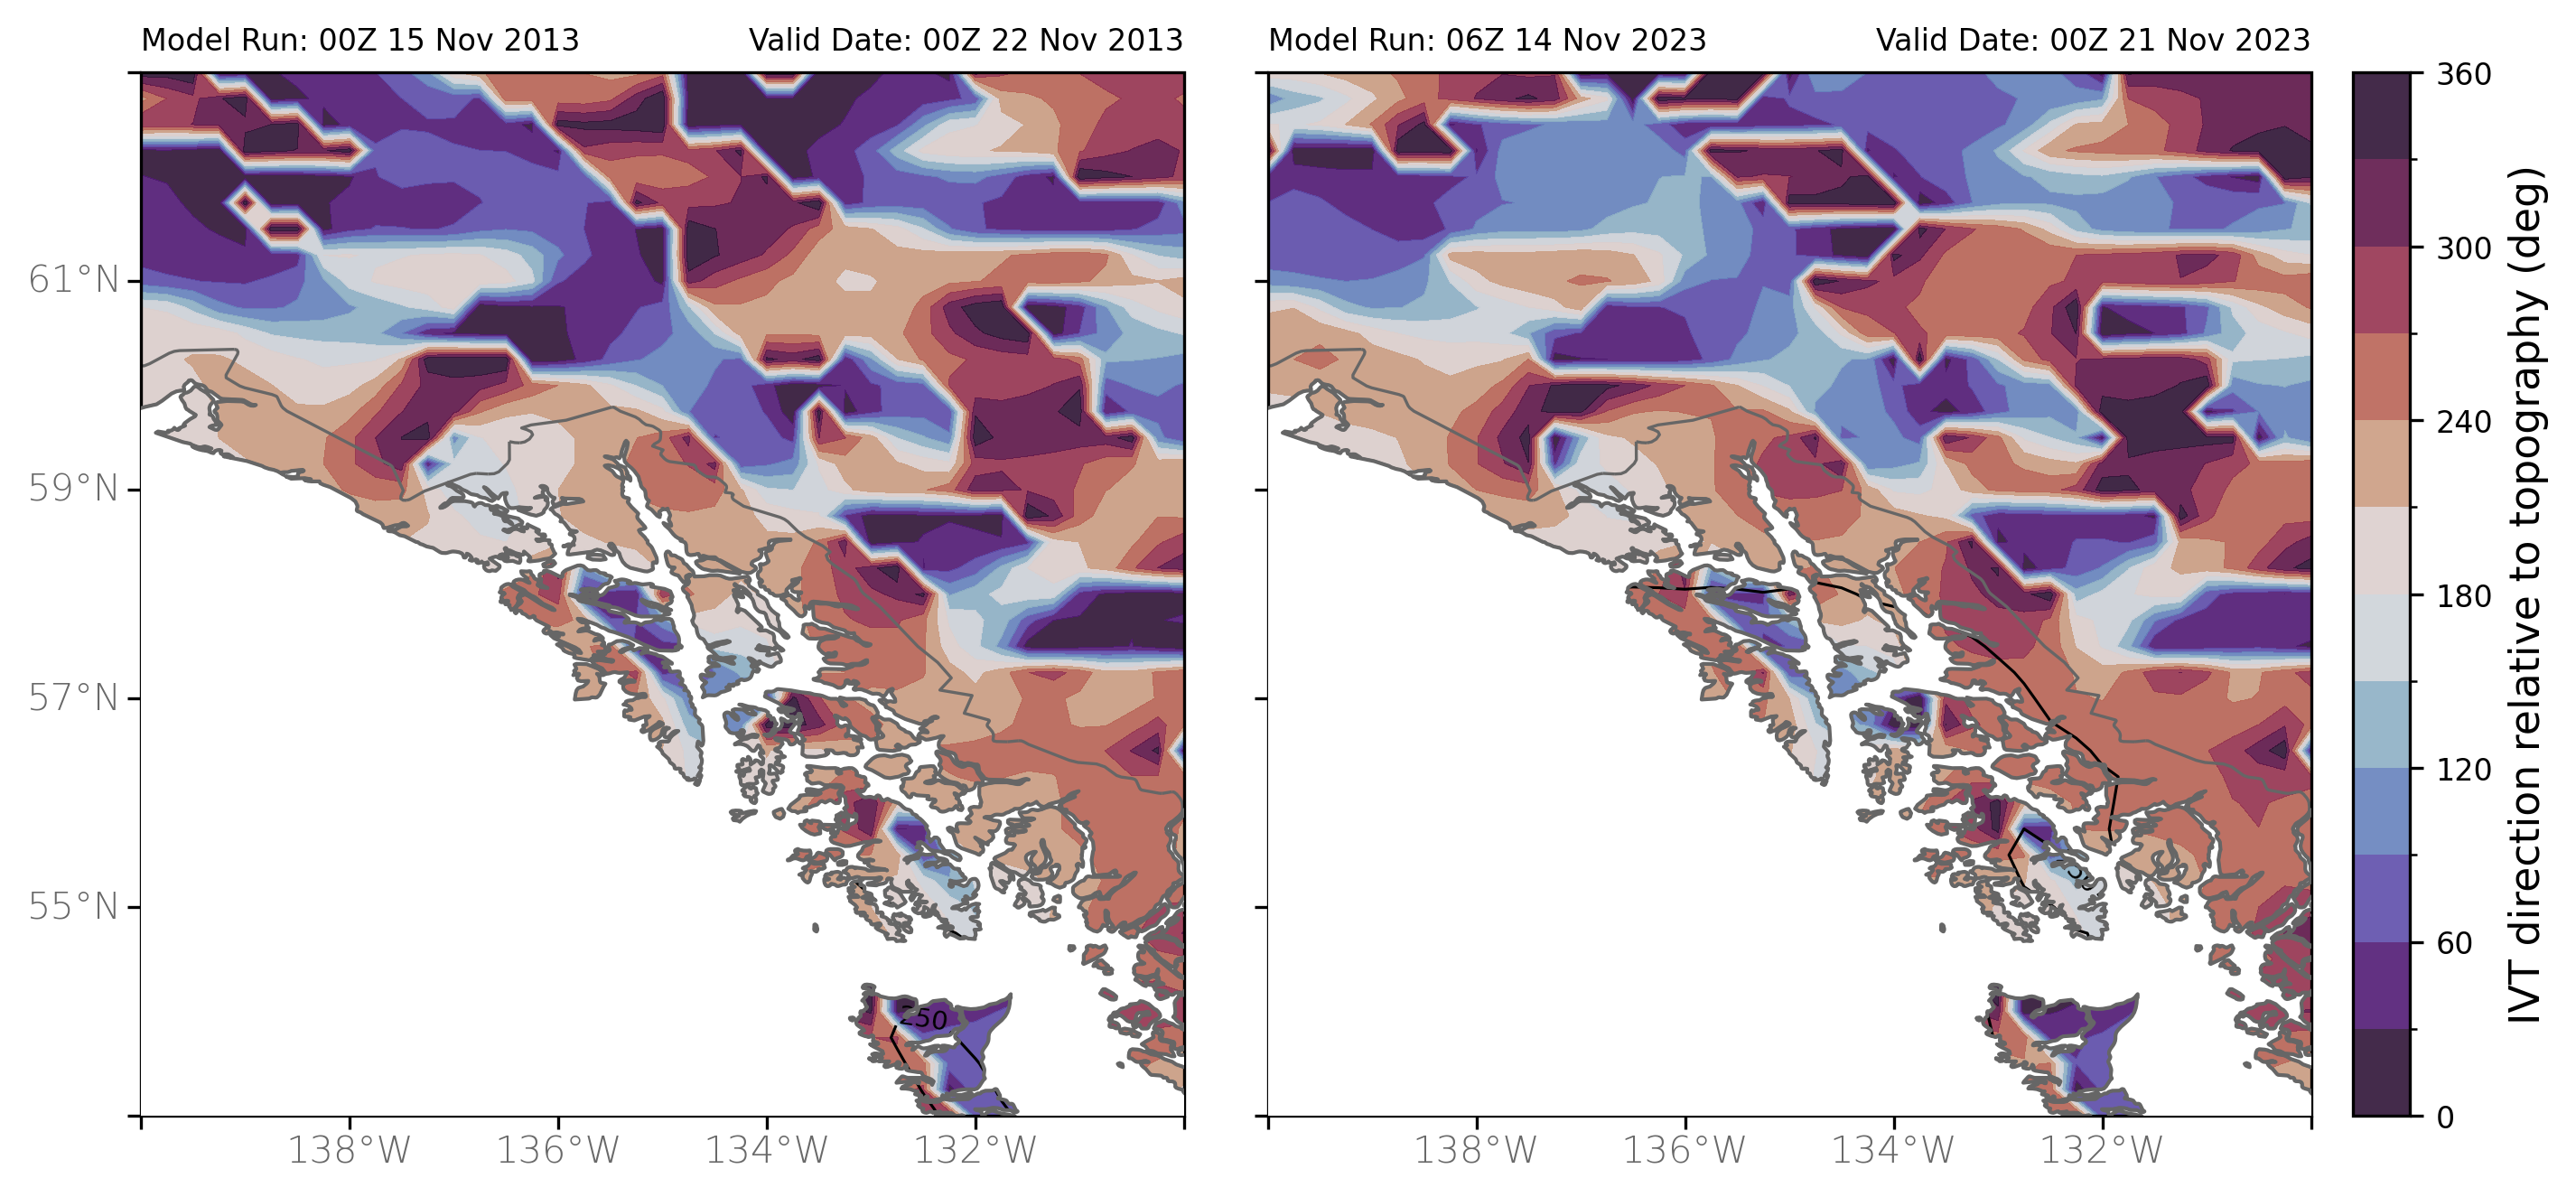

In [17]:
# Create figure
fig = plt.figure(figsize=(11, 5))
fig.dpi = 300
fname = path_to_figs + 'ams_poster_ivt_direction'
fmt = 'png'

nrows = 1
ncols = 3

# contour labels
kw_clabels = {'fontsize': 7, 'inline': True, 'inline_spacing': 7, 'fmt': '%i',
              'rightside_up': True, 'use_clabeltext': True}

kw_ticklabels = {'size': 10, 'color': 'dimgray', 'weight': 'light'}

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1], width_ratios = [1, 1, 0.05], wspace=0.001, hspace=0.05)
## use gs[rows index, columns index] to access grids

###################
### CLIMATOLOGY ###
###################
leftlats_lst = [True, False]
for i, fc in enumerate(fc_lst):
    ax = fig.add_subplot(gs[0, i], projection=mapcrs) 
    ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, left_lats=leftlats_lst[i], right_lats=False, bottom_lons=True,
                     mask_ocean=True)

    ## plot filled contours
    cmap = mpl.colormaps['twilight_shifted']
    bnds = np.arange(0, 365, 30)
    norm = mcolors.BoundaryNorm(bnds, cmap.N)
    
    data = fc.diff_dir.values
    cf = ax.contourf(fc.lon, fc.lat, data, transform=datacrs,
                     levels=bnds, cmap=cmap, norm=norm, alpha=0.9, extend='neither')
    # ## plot terrain
    # cf = plot_terrain(ax, ext)
    
    # # Plot colored normalized vectors 
    # data =  get_every_other_vector(fc.diff_dir.values)
    # cmap = cmo.phase
    # bnds = np.arange(0, 365, 5)
    # norm = mcolors.BoundaryNorm(bnds, cmap.N)
    
    # # vectors - normalized
    # uvec =  get_every_other_vector((fc.uIVT.values / fc.IVT.values))
    # vvec =  get_every_other_vector((fc.vIVT.values / fc.IVT.values))
    
    # kw_quiver = {'headlength': 6, 'headaxislength': 4.5, 'headwidth': 4.5}
    # Q = ax.quiver(lons, lats, uvec, vvec, data, cmap=cmap, norm=norm, alpha=0.8,
    #                         capstyle='round', units='width', scale_units='inches', scale=8., **kw_quiver)

    # Contour Lines
    clevs = np.arange(250., 2100., 250.)
    cs = ax.contour(lons, lats, fc.IVT.values, transform=datacrs,
                     levels=clevs, colors='k',
                     linewidths=0.75, linestyles='solid')
    plt.clabel(cs, **kw_clabels)
    
    ## add plot labels
    ts = pd.to_datetime(str(fc.time.values)) 
    init_time = ts.strftime('%HZ %d %b %Y')
    
    ts = pd.to_datetime(str(fc.valid_time.values)) 
    valid_time = ts.strftime('%HZ %d %b %Y')
    
    ax.set_title('Model Run: {0}'.format(init_time), loc='left', fontsize=8)
    ax.set_title('Valid Date: {0}'.format(valid_time), loc='right', fontsize=8)

# Add color bar
cbax = plt.subplot(gs[0,-1]) # colorbar axis
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'vertical', ticklocation = 'right')
cb.set_label('IVT direction relative to topography (deg)', fontsize=11)
cb.ax.tick_params(labelsize=8)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()